In this notebook we will study the energy conservation properties of several high-order methods for the Hénon–Heiles system. We will se how the energy error behaves at very thight tolerances and how different techniques such as using symplectic solvers or manifold projections benchmark against each other.
The Hamiltonian for this system is given by:
$$
\mathcal{H}=\frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}\left(q_1^2 + q_2^2 + 2q_1^2 q_2 - \frac{2}{3}q_2^3\right)
$$

In [5]:
using DifferentialEquations, Plots
using TaylorIntegration
pyplot()

T(p) = 1//2 * sum(p.^2)
V(q) = 1//2 * (q[1]^2 + q[2]^2 + 2q[1]^2 * q[2]- 2//3 * q[2]^3)
H(q, p) = T(p) + V(q)

function q̇(t, q, p, dq)
    dq[1] = p[1]
    dq[2] = p[2]
end

function ṗ(t, q, p, dp)
    dp[1] = -q[1] * (1 + 2q[2])
    dp[2] = -q[2] - (q[1]^2 - q[2]^2)
end

henon = @ode_def_noinvjac HamiltonEqs begin
    dq1 = p1
    dq2 = p2
    dp1 = -q1 * (1 + 2q2)
    dp2 = -q2 - (q1^2 - q2^2)
end

const q0 = [0.1, 0.]
const p0 = [0., 0.5]
const u0 = hcat(q0, p0)
const E = H(q0, p0)

function g(u, resid)
    resid[1,1] = H(u[1,:], u[2,:]) - E
    resid[1,2] = 0
    resid[2,:] .= 0
end

const cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13));

For the comparison we will use the following function

In [10]:
energy_err(t,u1,u2,u3,u4) = (t, H([u1,u2], [u3,u4]) - E)
energy_err(sol) = [abs.(H([sol[1,j], sol[2,j]], [sol[3,j], sol[4,j]]) - E) for j=1:size(sol,2)]

function compare(; tmax=1e2)
    prob1 = DynamicalODEProblem(q̇, ṗ, q0, p0, (0., tmax))
    prob2 = ODEProblem(henon, u0, (0., tmax))
    @time sol1 = solve(prob1, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14)
    @time sol2 = solve(prob1, KahanLi8(), dt=1e-2)
    @time sol3 = solve(prob1, Vern9(), abstol=1e-14, reltol=1e-14)
    @time sol4 = solve(prob1, DPRKN12(), abstol=1e-14, reltol=1e-14)
    @time sol5 = solve(prob2, TaylorMethod(50), abstol=1e-20)
    
    println("Vern9 + ManifoldProjection max energy error: ", maximum(energy_err(sol1)))
    println("KahanLi8 max energy error: ",                   maximum(energy_err(sol2)))
    println("Vern9 max energy error: ",                      maximum(energy_err(sol3)))
    println("DPRKN12 max energy error: ",                    maximum(energy_err(sol4)))
    println("TaylorMethod max energy error: ",               maximum(energy_err(sol5)))
    
    plot(xlabel="t", ylabel="Energy error")
    plot!(sol1, vars=(energy_err, 0,1,2,3,4), label="Vern9 + ManifoldProjection")
    plot!(sol2, vars=(energy_err, 0,1,2,3,4), label="KahanLi8")
    plot!(sol3, vars=(energy_err, 0,1,2,3,4), label="Vern9")
    plot!(sol4, vars=(energy_err, 0,1,2,3,4), label="DPRKN12")
    scatter!(sol5.t, map(i->H(hcat(sol5[1,i], sol5[2,i]), hcat(sol5[3,i], sol5[4,i]))-E, 
            1:size(sol5, 3)) , label="TaylorMethod")
end

compare (generic function with 1 method)

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error. 

 64.162143 seconds (313.80 M allocations: 9.733 GiB, 3.71% gc time)
  0.020969 seconds (190.20 k allocations: 10.318 MiB, 46.32% gc time)
  0.036688 seconds (1.58 M allocations: 26.838 MiB, 38.41% gc time)
  0.000820 seconds (9.00 k allocations: 407.922 KiB)
  0.040166 seconds (189.75 k allocations: 61.441 MiB, 59.04% gc time)
Vern9 + ManifoldProjection max energy error: 1.1102230246251565e-16
KahanLi8 max energy error: 4.9404924595819466e-15
Vern9 max energy error: 1.4988010832439613e-15
DPRKN12 max energy error: 2.220446049250313e-15
TaylorMethod max energy error: 2.7755575615628914e-17



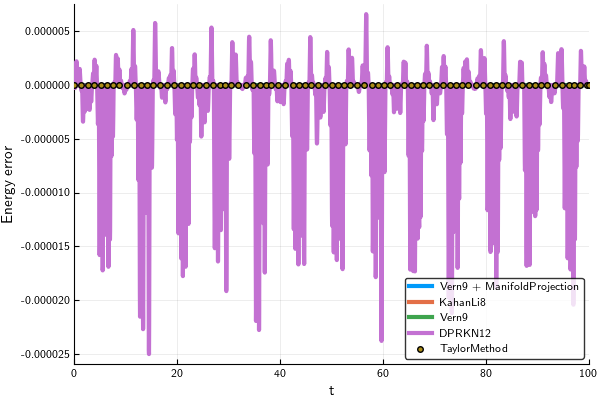

In [11]:
compare(tmax=1e2)

Because the energy error for the `Vern9` method is lower than the tolerance for `NLsolve`, this method and the `ManifoldProjection` version produce identical results.

656.562699 seconds (3.04 G allocations: 94.820 GiB, 4.07% gc time)
  0.285659 seconds (1.90 M allocations: 101.091 MiB, 58.53% gc time)
  0.890410 seconds (15.78 M allocations: 267.807 MiB, 72.70% gc time)
  0.005583 seconds (82.56 k allocations: 3.604 MiB)
  0.442896 seconds (1.88 M allocations: 268.962 MiB, 73.71% gc time)
Vern9 + ManifoldProjection max energy error: 2.7755575615628914e-16
KahanLi8 max energy error: 1.815214645262131e-14
Vern9 max energy error: 1.3933298959045715e-14
DPRKN12 max energy error: 3.1363800445660672e-15
TaylorMethod max energy error: 2.7755575615628914e-17



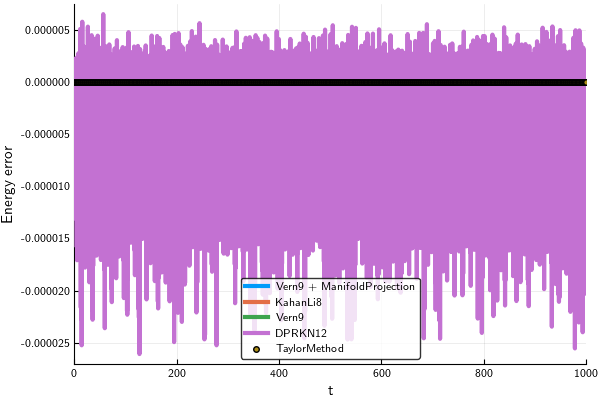

In [12]:
compare(tmax=1e3)

In [ ]:
compare(tmax=1e4)

In [ ]:
compare(tmax=5e4)

We can see that as the simulation time increases, the energy error increases. For this particular example the energy error for all the methods is comparable, but for smaller simulation times, if a highly accurate solution is required, the symplectic method is not recommended as its energy error fluctuations are relatively larger.
The above plot shows how the `Vern9` method and the `ManifoldProjection` version start to differ exactly when the energy error reaches the chosen tolerance for `NLsolve` (`ftol=1e-13`).